In [2]:
%pylab inline
import scipy
from numpy.fft import fft2, fftshift, ifftshift
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#272b30'
plt.rcParams['image.cmap'] = 'viridis' 

Populating the interactive namespace from numpy and matplotlib


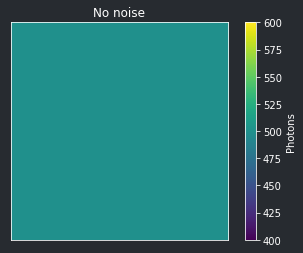

In [3]:
num_photons = 500
num_pixels  = 256
mu_p        = num_photons * np.ones((num_pixels, num_pixels))

fig, ax = plt.subplots()
img = ax.imshow(mu_p, vmin=400, vmax=600)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('No noise')

cb = plt.colorbar(img)
cb.set_label('Photons')

plt.show()

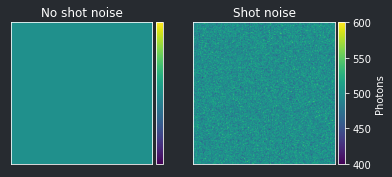

In [4]:
seed       = 42
rs         = np.random.RandomState(seed)
shot_noise = rs.poisson(num_photons, (num_pixels, num_pixels))

fig, (ax0, ax1) = plt.subplots(ncols=2)
img0 = ax0.imshow(mu_p, vmin=400, vmax=600)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title('No shot noise')

divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb0 = plt.colorbar(img0, cax=cax)
cb0.set_ticks([])

img1 = ax1.imshow(shot_noise, vmin=400, vmax=600)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Shot noise')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb1 = plt.colorbar(img1, cax=cax)
cb1.set_label('Photons')

plt.show()

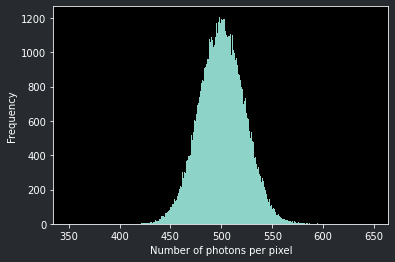

In [5]:
# It's also interesting to look at the distribution of photons hitting each pixel.
plt.hist(shot_noise.ravel(), bins=np.arange(350, 650))
plt.xlabel('Number of photons per pixel')
plt.ylabel('Frequency')
plt.show()

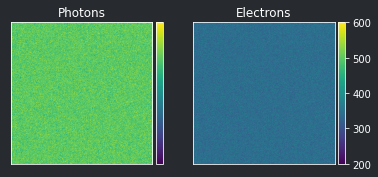

In [6]:
quantum_efficiency = 0.69
# Round the result to ensure that we have a discrete number of electrons
electrons = np.round(quantum_efficiency * shot_noise)

fig, (ax0, ax1) = plt.subplots(ncols=2)
img0 = ax0.imshow(shot_noise, vmin=200, vmax=600)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title('Photons')

divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb0 = plt.colorbar(img0, cax=cax)
cb0.set_ticks([])

img1 = ax1.imshow(electrons, vmin=200, vmax=600)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Electrons')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(img1, cax=cax)

plt.show()

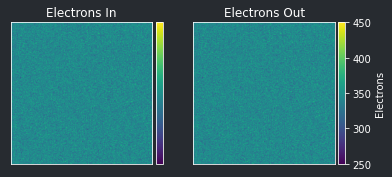

In [7]:
dark_noise = 2.29 # electrons
electrons_out = np.round(rs.normal(scale=dark_noise, size=electrons.shape) + electrons)

fig, (ax0, ax1) = plt.subplots(ncols=2)
img0 = ax0.imshow(electrons, vmin=250, vmax=450)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title('Electrons In')

divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb0 = plt.colorbar(img0, cax=cax)
cb0.set_ticks([])

img1 = ax1.imshow(electrons_out, vmin=250, vmax=450)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Electrons Out')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(img1, cax=cax)
cb.set_label('Electrons')

plt.show()

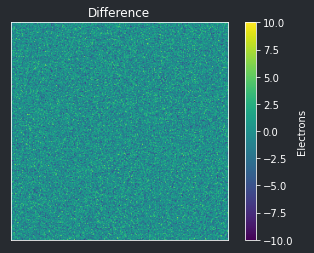

In [8]:
# Plot the difference between the two
fig, ax = plt.subplots()
img = ax.imshow(electrons - electrons_out, vmin=-10, vmax=10)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Difference')

cb = plt.colorbar(img)
cb.set_label('Electrons')

plt.show()

<ipython-input-9-17bc0a16aa52>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_adu     = np.int(2**bitdepth - 1)
<ipython-input-9-17bc0a16aa52>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for 

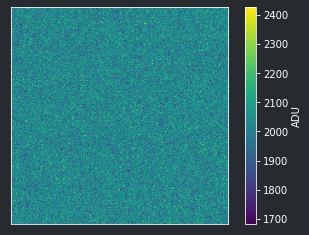

In [9]:
sensitivity = 5.88 # ADU/e-
bitdepth    = 12
max_adu     = np.int(2**bitdepth - 1)
adu         = (electrons_out * sensitivity).astype(np.int)
adu[adu > max_adu] = max_adu # models pixel saturation

fig, ax = plt.subplots()
img = ax.imshow(adu)
ax.set_xticks([])
ax.set_yticks([])

cb = plt.colorbar(img)
cb.set_label('ADU')

plt.show()

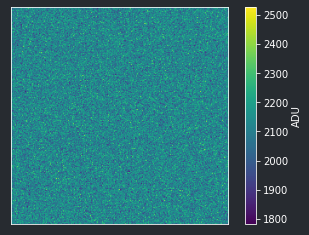

In [10]:
baseline  = 100 # ADU
adu      += baseline

# EDIT: Note that we could have easily just performed this next step once
# here, rather than in the previous step
adu[adu > max_adu] = max_adu


fig, ax = plt.subplots()
img = ax.imshow(adu)
ax.set_xticks([])
ax.set_yticks([])

cb = plt.colorbar(img)
cb.set_label('ADU')

plt.show()

In [11]:
# Ground truth: a circular phase-only object
numPixels = 512
gtRadius  = 50 # ground truth radius, pixels
gtPhase   = 0.75 # radians
gtCenter  = numPixels / 2 # assumes numPixels is even
W, H      = np.meshgrid(np.arange(0, numPixels), np.arange(0, numPixels)) # coordinates of the array indexes
gtMask    = np.sqrt((W - gtCenter)**2 + (H - gtCenter)**2) <= gtRadius # boundaries of the object
gt = np.ones((numPixels, numPixels), dtype=np.complex)
gt[gtMask] = np.exp(1j * gtPhase)

# Physical dimensions and sampling
pixelSize = 0.1 # microns
x = np.linspace(-pixelSize * numPixels / 2, pixelSize * numPixels / 2, num = numPixels, endpoint = True)

dx = x[1] - x[0]    # Sampling period, microns
fS = 1 / dx         # Spatial sampling frequency, inverse microns
df = fS / numPixels # Spacing between discrete frequency coordinates, inverse microns
fx = np.arange(-fS / 2, fS / 2, step = df) # Spatial frequency, inverse microns

# Fourier transform of ground truth
GT = ifftshift(fft2(fftshift(gt))) * dx**2

# Angular spectrum propagator and spatial frequencies
def H(fx, fy, z, wavelength=0.5):
    square_root = np.sqrt(1 - (wavelength**2 * fx**2) - (wavelength**2 * fy**2))
    temp = exp(1j * 2 * np.pi * z / wavelength * square_root)
    temp[np.isnan(temp)] = 0 # replace nan's with zeros
    return temp

FX, FY = np.meshgrid(fx, fx)

# Field at a distance of z=0
gt_prime = fftshift(ifft2(ifftshift(GT))) / dx**2

# Normalizing constant: makes the maximum photon count at z = 0 equal to 100 photons
norm = np.max(np.abs(gt_prime)**2) / 100

<ipython-input-11-42737cdf4b6e>:8: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gt = np.ones((numPixels, numPixels), dtype=np.complex)


In [16]:
hologram = np.abs(gt_prime)**2 / norm

In [18]:
# Function to add camera noise
def add_camera_noise(input_irrad_photons, qe=0.69, sensitivity=5.88,
                     dark_noise=2.29, bitdepth=12, baseline=100,
                     rs=np.random.RandomState(seed=42)):
 
    # Add shot noise
    photons = rs.poisson(input_irrad_photons, size=input_irrad_photons.shape)
    
    # Convert to electrons
    electrons = qe * photons
    
    # Add dark noise
    electrons_out = rs.normal(scale=dark_noise, size=electrons.shape) + electrons
    
    # Convert to ADU and add baseline
    max_adu     = np.int(2**bitdepth - 1)
    adu         = (electrons_out * sensitivity).astype(np.int) # Convert to discrete numbers
    adu += baseline
    adu[adu > max_adu] = max_adu # models pixel saturation
    
    return adu

In [21]:
hologram

array([[100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       ...,
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.]])